In [1]:
%matplotlib inline

import pandas as pd
#import pandas_ml as pdml

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cPickle as pkl
from sklearn.datasets import make_moons, make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from IPython.display import SVG
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from collections import Counter

from flip_gradient import flip_gradient
from utils import *

In [2]:
all_features_by_week = pd.read_csv('ncu_data_week_1-18(3a).csv', sep=',')
all_features_by_week.drop(['username'], axis=1, inplace=True)

# resample from 59 to 128
#for i in range(128-59):
#    all_features_by_week = all_features_by_week.append(all_features_by_week.sample(1))


feature_header = list(all_features_by_week)[0 : 19]
cluster_header = 'cluster'
_Xt = all_features_by_week[feature_header].values
_yt = all_features_by_week[cluster_header].values
#all_features_by_week.describe()

## oversampling
ada = ADASYN()
sampled_Xt, sampled_yt = ada.fit_sample(_Xt, _yt)
#Counter(sampled_Xt)

dataframe_Xt = pd.DataFrame(data=sampled_Xt, columns=feature_header)
dataframe_yt = pd.DataFrame(data=sampled_yt, columns=['cluster'])
dataframe_target = pd.concat([dataframe_Xt, dataframe_yt], axis=1)

for i in range(198-37-38):
    dataframe_target = dataframe_target.append(dataframe_target.sample(1))
    
Xt = dataframe_target[feature_header].values
yt = dataframe_target[cluster_header].values

In [3]:
#all_features_by_week = pd.read_csv('ncu_data_week_chkb_1-6(59).csv', sep=',')
all_features_by_week = pd.read_csv('ncu_data_week_1-6.csv', sep=',')
all_features_by_week.drop(['username'], axis=1, inplace=True)

feature_header = list(all_features_by_week)[0 : 19]
cluster_header = 'cluster'
_Xs = all_features_by_week[feature_header].values
_ys = all_features_by_week[cluster_header].values
#all_features_by_week.describe()

Xs, ys = ada.fit_sample(_Xs, _ys)
Counter(ys)

Counter({0: 100, 1: 98})

In [4]:

#dataframe_target = pd.concat([pd.DataFrame(data=_Xt), pd.DataFrame(data=_yt)], axis=1)
#dataframe_target['type'] = 0 # target
#dataframe_source = pd.concat([pd.DataFrame(data=_Xs), pd.DataFrame(data=_ys)], axis=1)
#dataframe_source['type'] = 1 # source
#dataframe_sample = pd.concat([dataframe_target, dataframe_source], ignore_index=True)

## oversampling
#sample_x = dataframe_sample[list(dataframe_sample)[0:-1]].values
#sample_y = dataframe_sample['type'].values
#sampled_x, sampled_y = ada.fit_sample(sample_x, sample_y)

## divided into target and source
#sampled_target = dataframe_sampled[dataframe_sampled.iloc[:,-1] == 0]
#sampled_source = dataframe_sampled[dataframe_sampled.iloc[:,-1] == 1]

#feature_header = list(sampled_target)[0 : 19]
#cluster_header = 'cluster'
#Xt = sampled_target[feature_header].values
#yt = sampled_target.iloc[:,-2].values

In [5]:
# create testing data set
num_test = 100
combined_test_data = np.concatenate([Xs[:num_test], Xt[:num_test]])
combined_test_labels = np.concatenate([ys[:num_test], yt[:num_test]])
combined_test_domain = np.concatenate([np.tile([1., 0.], [num_test, 1]),
        np.tile([0., 1.], [num_test, 1])])

In [6]:
#batch_size = 16
batch_size = 49

def build_model(shallow_domain_classifier=True):
    X = tf.placeholder(tf.float32, [None, 19], name='X') # Input data
    Y_index = tf.placeholder(tf.int32, [None], name='Y_index')  # Class index
    D_index = tf.placeholder(tf.int32, [None], name='D_index')  # Domain index
    train = tf.placeholder(tf.bool, [], name='train')       # Switch for routing data to class predictor
    l = tf.placeholder(tf.float32, [], name='l')        # Gradient reversal scaler
    
    Y = tf.one_hot(Y_index, 2)
    D = tf.one_hot(D_index, 2)

    
    # Feature extractor - single layer
    W0 = weight_variable([19, 38])
    b0 = bias_variable([38])
    F = tf.nn.relu(tf.matmul(X, W0) + b0, name='feature')
    
    
    
    # Label predictor - single layer
    f = tf.cond(train, lambda: tf.slice(F, [0, 0], [batch_size / 2, -1]), lambda: F)
    y = tf.cond(train, lambda: tf.slice(Y, [0, 0], [batch_size / 2, -1]), lambda: Y)

    W1 = weight_variable([38, 2])
    b1 = bias_variable([2])
    
    p_logit = tf.matmul(f, W1) + b1
    p = tf.nn.softmax(p_logit)
    p_loss = tf.nn.softmax_cross_entropy_with_logits(logits=p_logit, labels=y)

    
    
    # Domain predictor - shallow
    f_ = flip_gradient(F, l)

    if shallow_domain_classifier:
        W2 = weight_variable([38, 2])
        b2 = bias_variable([2])
        d_logit = tf.matmul(f_, W2) + b2
        d = tf.nn.softmax(d_logit)
        d_loss = tf.nn.softmax_cross_entropy_with_logits(logits=d_logit, labels=D)

    else:
        W2 = weight_variable([38, 8])
        b2 = bias_variable([8])
        h2 = tf.nn.relu(tf.matmul(f_, W2) + b2)

        W3 = weight_variable([8, 2])
        b3 = bias_variable([2])
        d_logit = tf.matmul(h2, W3) + b3
        d = tf.nn.softmax(d_logit)
        d_loss = tf.nn.softmax_cross_entropy_with_logits(logits=d_logit, labels=D)


        
        
    # Optimization
    pred_loss = tf.reduce_sum(p_loss, name='pred_loss')
    domain_loss = tf.reduce_sum(d_loss, name='domain_loss')
    total_loss = tf.add(pred_loss, domain_loss, name='total_loss')

    pred_train_op = tf.train.AdamOptimizer(0.01).minimize(pred_loss, name='pred_train_op')
    dann_train_op = tf.train.AdamOptimizer(0.01).minimize(total_loss, name='dann_train_op')

    
    # Evaluation
    p_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(p, 1)), tf.float32), name='p_acc')
    d_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(D, 1), tf.argmax(d, 1)), tf.float32), name='d_acc')

In [7]:

build_model()

sess = tf.InteractiveSession()

def train_and_evaluate(sess, 
                       train_op_name, 
                       train_loss_name, 
                       model='dann', 
                       grad_scale=None, 
                       num_batches=10000, 
                       verbose=True):
    
    # Create batch builders
    S_batches = batch_generator([Xs, ys], batch_size / 2)
    T_batches = batch_generator([Xt, yt], batch_size / 2)
    
    # Get output tensors and train op
    d_acc = sess.graph.get_tensor_by_name('d_acc:0')
    p_acc = sess.graph.get_tensor_by_name('p_acc:0')
    train_loss = sess.graph.get_tensor_by_name(train_loss_name + ':0')
    train_op = sess.graph.get_operation_by_name(train_op_name)
    
    
    writer = tf.summary.FileWriter('/notebooks/tf-dann/model-test', graph = sess.graph)
    sess.run(tf.global_variables_initializer())
    for i in range(num_batches):

        # If no grad_scale, use a schedule
        if grad_scale is None:
            p = float(i) / num_batches
            lp = 2. / (1. + np.exp(-10. * p)) - 1
        else:
            lp = grad_scale

        if model == 'dann':
            X0, y0 = S_batches.next()
            X1, y1 = T_batches.next()

            Xb = np.vstack([X0, X1])
            yb = np.hstack([y0, y1])
            D_labels = np.hstack([np.zeros(batch_size / 2, dtype=np.int32),
                                  np.ones(batch_size / 2, dtype=np.int32)])

            _, loss, da, pa = sess.run([train_op, train_loss, d_acc, p_acc],
                                       feed_dict={'X:0': Xb, 
                                                  'Y_index:0': yb, 
                                                  'D_index:0': D_labels,
                                                  'train:0': True, 
                                                  'l:0': lp})

            if verbose and i % (num_batches / 5) == 0:
                print 'loss: %f, domain accuracy: %f, class accuracy: %f' % (loss, da, pa)
                
        elif model == 'source':
            X0, y0 = S_batches.next()
            Xb = np.vstack([X0])
            yb = np.hstack([y0])
            D_labels = np.hstack([np.zeros(batch_size / 4, dtype=np.int32),
                                  np.ones(batch_size / 4, dtype=np.int32)])
            
            _, loss, da, pa = sess.run([train_op, train_loss, d_acc, p_acc],
                                       feed_dict={'X:0': Xb, 
                                                  'Y_index:0': yb, 
                                                  'D_index:0': D_labels,
                                                  'train:0': True, 
                                                  'l:0': lp})
            if verbose and i % (num_batches / 5) == 0:
                print 'loss: %f, domain accuracy: %f, class accuracy: %f' % (loss, da, pa)

        elif model == 'target':
            X0, y0 = T_batches.next()
            Xb = np.vstack([X0])
            yb = np.hstack([y0])
            D_labels = np.hstack([np.zeros(batch_size / 4, dtype=np.int32),
                                  np.ones(batch_size / 4, dtype=np.int32)])
            
            _, loss, da, pa = sess.run([train_op, train_loss, d_acc, p_acc],
                                       feed_dict={'X:0': Xb, 
                                                  'Y_index:0': yb, 
                                                  'D_index:0': D_labels,
                                                  'train:0': True, 
                                                  'l:0': lp})
            if verbose and i % (num_batches / 5) == 0:
                print 'loss: %f, domain accuracy: %f, class accuracy: %f' % (loss, da, pa)
                
                
    # Get final accuracies on whole dataset
    das, acc_source_classification = sess.run([d_acc, p_acc], feed_dict={'X:0': Xs, 
                                                   'Y_index:0': ys, 
                                                   'D_index:0': np.zeros(Xs.shape[0], dtype=np.int32), 
                                                   'train:0': False, 
                                                   'l:0': 1.0})
    dat, acc_target_classification = sess.run([d_acc, p_acc], feed_dict={'X:0': Xt, 
                                                   'Y_index:0': yt,
                                                   'D_index:0': np.ones(Xt.shape[0], dtype=np.int32), 
                                                   'train:0': False, 
                                                   'l:0': 1.0})
    dax, acc_domain_classification = sess.run([d_acc, p_acc], feed_dict={'X:0': combined_test_data, 
                                                   'Y_index:0': combined_test_domain.argmax(1),
                                                   'D_index:0': np.ones(combined_test_data.shape[0], dtype=np.int32), 
                                                   'train:0': False, 
                                                   'l:0': 1.0})
    
    result_feature_extraction = sess.run('feature:0', feed_dict={'X:0': combined_test_data})
    
    return acc_source_classification, acc_target_classification, acc_domain_classification, result_feature_extraction


Source only training
+ Source (MNIST) accuracy: 0.9847
+ Target (MNIST-M) accuracy: 0.5463

Domain adaptation training
+ Source (MNIST) accuracy: 0.9779
+ Target (MNIST-M) accuracy: 0.7141
+ Domain accuracy: 0.693

In [11]:
num_batches=10000
grad_scale=0.2
verbose=False

print '\nSource only training'
source_acc, target_acc, _, source_only_emb = train_and_evaluate(sess, 
                                               'pred_train_op', 
                                               'pred_loss', 
                                               verbose=verbose, 
                                               model='source',
                                               grad_scale=grad_scale,
                                               num_batches=num_batches)
print 'Source (Senior) accuracy: (Apply source model to source)', source_acc
print 'Target (College) accuracy: (Apply source model to target)', target_acc


print '\nTarget only training'
source_acc, target_acc, _, target_only_emb = train_and_evaluate(sess, 
                                               'pred_train_op', 
                                               'pred_loss', 
                                               verbose=verbose, 
                                               model='target',
                                               grad_scale=grad_scale,
                                               num_batches=num_batches)
print 'Source (Senior) accuracy: (Apply target model to source)', source_acc
print 'Target (College) accuracy: (Apply target model to target)', target_acc

print '\nDomain adaptation training'
source_acc, target_acc, d_acc, dann_emb = train_and_evaluate(sess, 
                                                   'dann_train_op', 
                                                   'total_loss', 
                                                   verbose=verbose, 
                                                   model='dann',
                                                   grad_scale=grad_scale,
                                                   num_batches=num_batches)

print 'Source (Senior) accuracy (Apply domain model to source):', source_acc
print 'Target (College) accuracy (Apply domain model to target):', target_acc

print '\nDomain classification accuracy:', d_acc


Source only training
Source (Senior) accuracy: (Apply source model to source) 1.0
Target (College) accuracy: (Apply source model to target) 0.434343

Target only training
Source (Senior) accuracy: (Apply target model to source) 0.580808
Target (College) accuracy: (Apply target model to target) 0.843434

Domain adaptation training
Source (Senior) accuracy (Apply domain model to source): 1.0
Target (College) accuracy (Apply domain model to target): 0.732323

Domain classification accuracy: 0.635


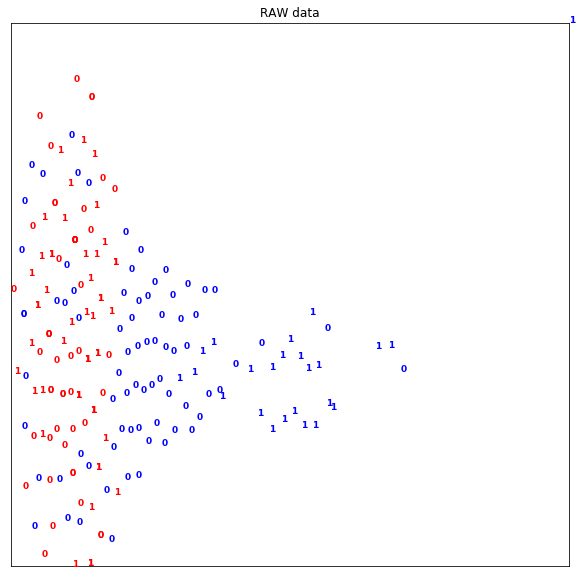

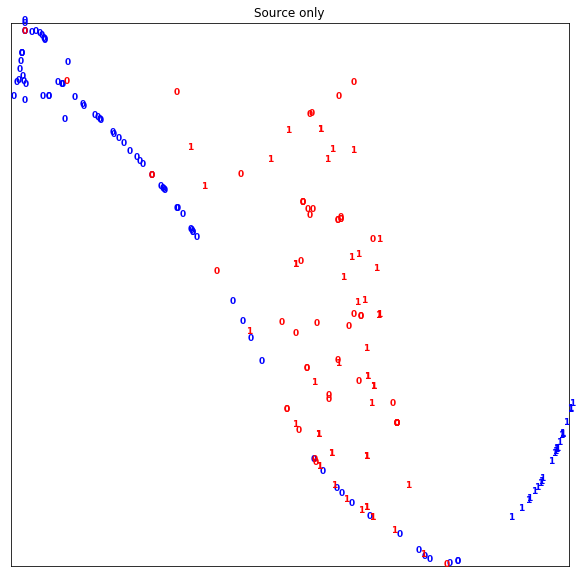

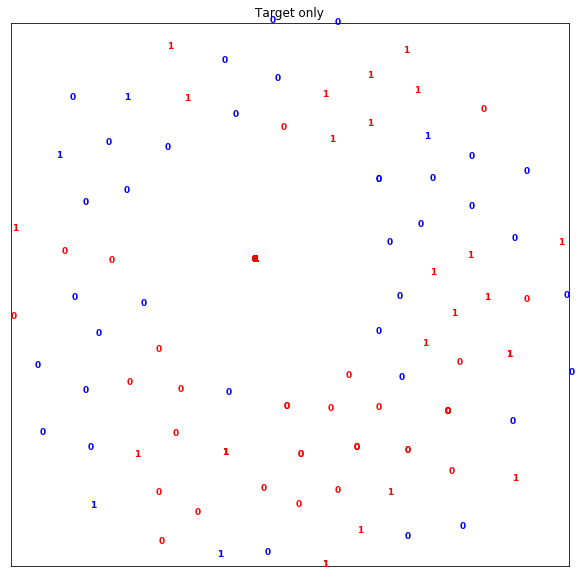

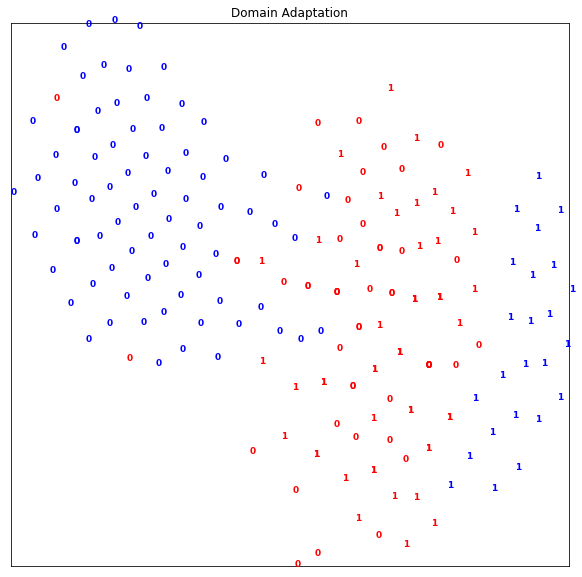

In [12]:
n_iter=1500
perplexity=100

tsne = TSNE(perplexity=perplexity, n_components=2, init='pca', n_iter=n_iter)
source_only_tsne = tsne.fit_transform(combined_test_data)
plot_embedding(source_only_tsne, 
               combined_test_labels, 
               combined_test_domain.argmax(1), 
               'RAW data')

tsne = TSNE(perplexity=perplexity, n_components=2, init='pca', n_iter=n_iter)
source_only_tsne = tsne.fit_transform(source_only_emb)
plot_embedding(source_only_tsne, 
               combined_test_labels, 
               combined_test_domain.argmax(1), 
               'Source only')

tsne = TSNE(perplexity=perplexity, n_components=2, init='pca', n_iter=n_iter)
target_only_tsne = tsne.fit_transform(target_only_emb)
plot_embedding(target_only_tsne, 
               combined_test_labels, 
               combined_test_domain.argmax(1), 
               'Target only')

tsne = TSNE(perplexity=perplexity, n_components=2, init='pca', n_iter=n_iter)
dann_tsne = tsne.fit_transform(dann_emb)
plot_embedding(dann_tsne, 
               combined_test_labels,
               combined_test_domain.argmax(1),
               'Domain Adaptation')